In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import mne

In [14]:
import numpy as np
import mne
import entropy as ent
import neurokit2 as nk
from scipy.signal import welch
from nolds import lyap_r
import antropy as ant

# Putting in the Epochs

In [4]:
participantsInfo = pd.read_table('./ds004504/participants.tsv')

In [59]:
#Getting all the groups
A_sub = participantsInfo[participantsInfo["Group"] == "A"]["participant_id"].tolist()
C_sub = participantsInfo[participantsInfo["Group"] == "C"]["participant_id"].tolist()
F_sub = participantsInfo[participantsInfo["Group"] == "F"]["participant_id"].tolist()
all_subs = participantsInfo["participant_id"].to_list()
print(all_subs)

['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032', 'sub-033', 'sub-034', 'sub-035', 'sub-036', 'sub-037', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-046', 'sub-047', 'sub-048', 'sub-049', 'sub-050', 'sub-051', 'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-059', 'sub-060', 'sub-061', 'sub-062', 'sub-063', 'sub-064', 'sub-065', 'sub-066', 'sub-067', 'sub-068', 'sub-069', 'sub-070', 'sub-071', 'sub-072', 'sub-073', 'sub-074', 'sub-075', 'sub-076', 'sub-077', 'sub-078', 'sub-079', 'sub-080', 'sub-081', 'sub-082', 'sub-083', 'sub-084', 'sub-085', 'sub-086', 'sub-087', 'sub-088']


In [58]:
#putting in the epocks, should I combine into one large recording for each group? I think no

['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032', 'sub-033', 'sub-034', 'sub-035', 'sub-036']


In [7]:
def derivativesPath(sub):
    return f"ds004504/{sub}/eeg/{sub}_task-eyesclosed_eeg.set"

In [11]:
#testing the sliding window with a tsingle participant 

raw = mne.io.read_raw_eeglab(derivativesPath(A_sub[0]), preload=True)

In [12]:
#parameters
window_length = 1.5
step_size = .75 #50% sliding window
sfreq = raw.info['sfreq']


start_times = np.arange(0, raw.times[-1] - window_length, step_size)
events = np.array([
    [int(t * sfreq), 0, 1] for t in start_times  # MNE event format
])

# Create epochs with a fixed window size
epochs = mne.Epochs(
    raw, events, event_id=1,
    tmin=0, tmax=window_length,
    baseline=None, detrend=1, preload=True
)

# Now, `epochs` contains your sliding windows
print(epochs)

Not setting metadata
798 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 798 events and 751 original time points ...
0 bad epochs dropped
<Epochs | 798 events (all good), 0 – 1.5 s (baseline off), ~86.9 MB, data loaded,
 '1': 798>


In [18]:
# for each ephoch ... for each electrode ... calculate band power for Delta through Beta waves ... use numpy or MNE ? i htink do raw.computer_psd() then split it into parts for each pand

Notes about how to approach:

Option 1

 get_data

 fmin, fmax: float

    The lower- and upper-bound on frequencies of interest. Default is fmin=0, fmax=np.inf (spans all frequencies present in the data)
    excludelist of str | ‘bads’

exclude:
    Channel names to exclude. If 'bads', channels in spectrum.info['bads'] are excluded; pass an empty list to include all channels (including “bad” channels, if any). 
    picksstr | array_like | slice | None

picks: str | array_like | slice | None
    Channels to include. Slices and lists of integers will be interpreted as channel indices. In lists, channel type strings (e.g., ['meg', 'eeg']) will pick channels of those types, channel name strings (e.g., ['MEG0111', 'MEG2623'] will pick the given channels. Can also be the string values 'all' to pick all channels, or 'data' to pick data channels. None (default) will pick good data channels (excluding reference MEG channels). Note that channels in info['bads'] will be included if their names or indices are explicitly provided. 


Option 2 

 to_data_frame(picks=None, index=None, copy=True, long_format=False, *, verbose=None)
[source]
long_formatbool

    If True, the DataFrame is returned in long format where each row is one observation of the signal at a unique combination of frequency and channel. For convenience, a ch_type column is added to facilitate subsetting the resulting DataFrame. Defaults to False. 


**Conclusion**

I think that option 1 is better with get data as we can direckly pick the channel and frequency. I think that the reference channels have been removed so no need to worry about that :).

In [16]:
# Ok now we will do option 1. We will get the list of channels and the list of band ranges for each epoch.

In [60]:
channel_names = raw.info['ch_names']
print(channel_names)
# ** checking all subs have the same channels 
for sub in all_subs:
    raw_sub = mne.io.read_raw_eeglab(derivativesPath(sub), preload=True)
    if raw_sub.info['ch_names'] == channel_names:
        print(sub, "Good")
    else:
        print(sub, "no good")
        print(channel_names)
        print(raw_sub.info['ch_names'])

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
sub-001 Good
sub-002 Good
sub-003 Good
sub-004 Good
sub-005 Good
sub-006 Good
sub-007 Good
sub-008 Good
sub-009 Good
sub-010 Good
sub-011 Good
sub-012 Good
sub-013 Good
sub-014 Good
sub-015 Good
sub-016 Good
sub-017 Good
sub-018 Good
sub-019 Good
sub-020 Good
sub-021 Good
sub-022 Good
sub-023 Good
sub-024 Good
sub-025 Good
sub-026 Good
sub-027 Good
sub-028 Good
sub-029 Good
sub-030 Good
sub-031 Good
sub-032 Good
sub-033 Good
sub-034 Good
sub-035 Good
sub-036 Good
sub-037 Good
sub-038 Good
sub-039 Good
sub-040 Good
sub-041 Good
sub-042 Good
sub-043 Good
sub-044 Good
sub-045 Good
sub-046 Good
sub-047 Good
sub-048 Good
sub-049 Good
sub-050 Good
sub-051 Good
sub-052 Good
sub-053 Good
sub-054 Good
sub-055 Good
sub-056 Good
sub-057 Good
sub-058 Good
sub-059 Good
sub-060 Good
sub-061 Good
sub-062 Good
sub-063 Good
sub-064 Good
sub-065 Good
sub-066 Good
sub-067 Good
sub-068 Good

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


/Users/admin/neuro-venv/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/admin/neuro-venv/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


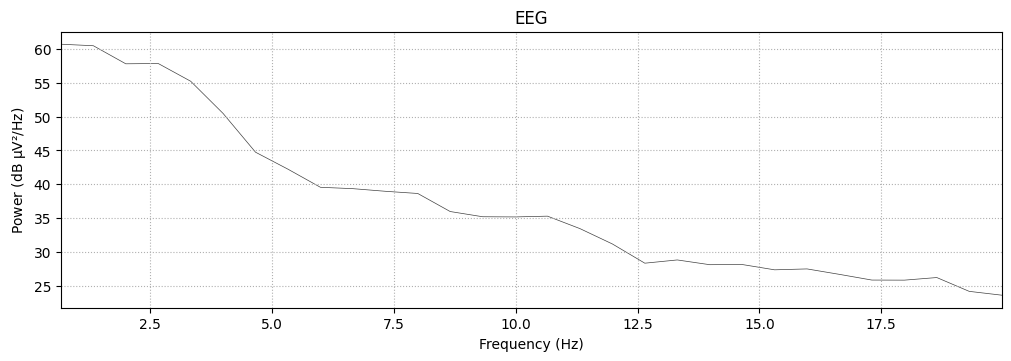

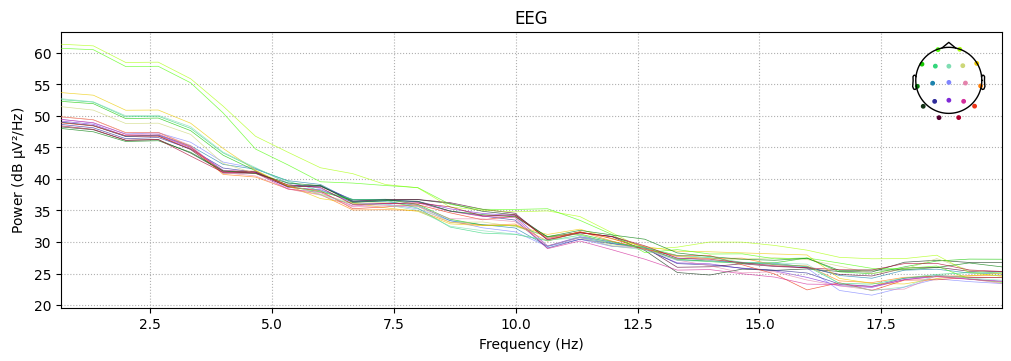

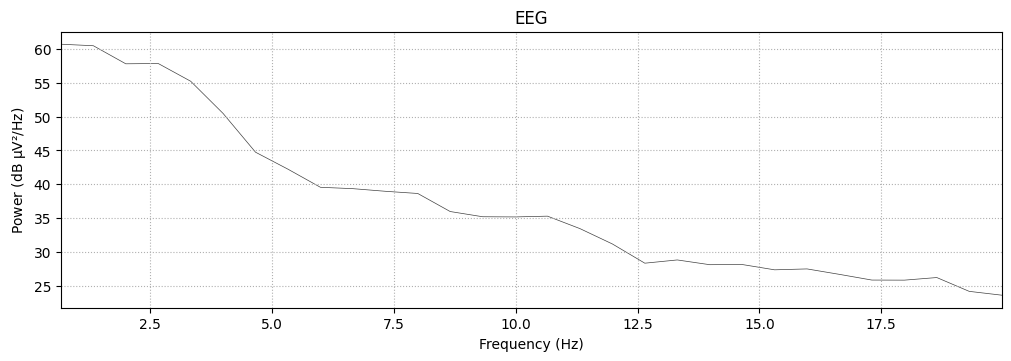

In [50]:
#can do epochs[ epochs index ] . picks (channel ) . compute_psd(range)

#!! try the other 'wlch' method tooo!
an_epochs_psd = epochs[0].compute_psd(method='multitaper', fmin=0.1, fmax=20.0)
an_epochs_psd.plot() # this plots all channels *tested works*
an_epochs_psd.plot(picks=channel_names[0]) # this plots a channel *tested works*


In [55]:
#setup for the big processing time 



freq_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 40),
}

#average band power, could look into making it relative
print(an_epochs_psd.get_data(fmin=0.1, fmax=20).mean(axis=-1)) #the average PSD for each epoch, 1 for each channel


[[1.35588451e-07 1.58178892e-07 2.28869206e-08 1.79116014e-08
  1.18332286e-08 1.28853417e-08 1.09507056e-08 1.21630528e-08
  1.15403539e-08 1.02628337e-08 2.15753225e-08 2.84397226e-08
  9.96943751e-09 1.28052242e-08 1.03202138e-08 1.13566985e-08
  2.34474888e-08 1.27321757e-08 1.18249256e-08]]


In [ ]:
'''
for x in range epochs:
    epoch = epochs[x]
    for band, (fmin, fmax) in freq_bands.itms():
        psd_band = spectrum.get_data
    
'''

In [ ]:
#getting the frequency bands accross all channels accross all for this epoch
freq_bands = [(0.5,4),(4,8), (8,12), 12,30)] #frequency bands: delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–12 Hz) and beta (12–30 Hz)
#!!!! try both welch and multitaper !!!!
# an_epochs_psd_freqs = [an_pochs_psd[channel_names[0]](method='welch', fmin=f[0], fmax=f[1]

ValueError: x and y must have same first dimension, but have shapes (2,) and (1, 19, 30)

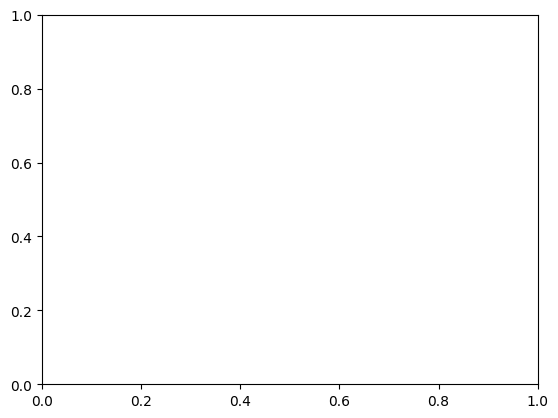

In [40]:
psds, freqs = mne.time_frequency.psd_welch(
    epochs[3].pick("Cz"), fmin=1, fmax=40, n_fft=256
)k


plt.plot(freqs, psds[0])  # Plot PSD of Cz for epoch index 3
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB/Hz)")
plt.title("PSD of Cz Channel (Epoch 3)")
plt.show()

In [ ]:
psds, freqs = mne.time_frequency.psd_welch(
    epochs[3].pick(channel_names[0]), fmin=1, fmax=40, n_fft=256
)
psds, freqs = mne.time_frequency.psd_multitaper(
    epochs[3].pick(channel_names[0]), fmin=1, fmax=40, n_fft=256
)
'''
# here are some other methods too ... https://mne.tools/stable/auto_examples/time_frequency/time_frequency_simulated.html
Two methods to do the computation ... 
Feature	Welch (psd_welch)	Multitaper (psd_multitaper)
Speed	                ✅ Faster	❌ Slower
Frequency Resolution	❌ Lower	✅ Higher
Handles Non-Stationary Data	❌ Not well	✅ Better
Best for Large Datasets	      ✅ Yes	❌ No
Best for Short Data Segments	❌ No	✅ Yes
Default Windowing	Hanning	Slepian Tapers
'''

